COMPARATIVE STUDY WITH RIDGE, LASSO, RF, XGB,LGBM,MLP.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor




def evaluate_model(y_true, y_pred, name="Model"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name}: RMSE={rmse:.3f} | MAE={mae:.3f} | R²={r2:.3f}")
    return rmse, mae, r2




df = pd.read_excel("/content/final.xlsx")


if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")  
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Quarter"] = df["Date"].dt.quarter
    df = df.drop(columns=["Date"])  




targets = ["Growth_Score","Profitability_Score","Stability_Score","Sector_Score","Overall_Score"]
X = df.drop(columns=targets, errors="ignore")
y = df[targets]


X = X.select_dtypes(include=[np.number])


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Step 3: Base Models

base_models = {
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01, max_iter=5000),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6,
                            subsample=0.8, colsample_bytree=0.8, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=-1, random_state=42),
    "MLP": MLPRegressor(hidden_layer_sizes=(128,64), activation="relu",
                        solver="adam", max_iter=500, random_state=42)
}

results = {}




for target in y.columns:
    print(f"\n===== Target: {target} =====")
    y_train_t, y_val_t = y_train[target], y_val[target]

    results[target] = {}

    for name, model in base_models.items():
        model.fit(X_train, y_train_t)
        y_pred = model.predict(X_val)
        results[target][name] = evaluate_model(y_val_t, y_pred, name)


# Stacking Ensemble

stack_models = [
    ("rf", RandomForestRegressor(n_estimators=200, random_state=42)),
    ("xgb", XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)),
    ("lgbm", LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42)),
]

final_ensembles = {}

for target in y.columns:
    print(f"\n===== Ensemble for: {target} =====")
    y_train_t, y_val_t = y_train[target], y_val[target]

    stack = StackingRegressor(
        estimators=stack_models,
        final_estimator=Ridge(alpha=1.0),
        passthrough=True
    )

    stack.fit(X_train, y_train_t)
    y_pred = stack.predict(X_val)

    final_ensembles[target] = evaluate_model(y_val_t, y_pred, "StackingEnsemble")



===== Target: Growth_Score =====
Ridge: RMSE=1.416 | MAE=0.728 | R²=0.007


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.119e+02, tolerance: 1.229e+00
  model = cd_fast.enet_coordinate_descent(


Lasso: RMSE=1.416 | MAE=0.727 | R²=0.006
RandomForest: RMSE=1.333 | MAE=0.684 | R²=0.119
XGBoost: RMSE=1.321 | MAE=0.682 | R²=0.135
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2782
[LightGBM] [Info] Number of data points in the train set: 6059, number of used features: 16
[LightGBM] [Info] Start training from score 31.121702
LightGBM: RMSE=1.346 | MAE=0.701 | R²=0.102
MLP: RMSE=9.831 | MAE=4.592 | R²=-46.907

===== Target: Profitability_Score =====
Ridge: RMSE=1.315 | MAE=0.540 | R²=0.271


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.690e+02, tolerance: 2.568e+00
  model = cd_fast.enet_coordinate_descent(


Lasso: RMSE=1.315 | MAE=0.539 | R²=0.272
RandomForest: RMSE=0.528 | MAE=0.143 | R²=0.882
XGBoost: RMSE=0.667 | MAE=0.117 | R²=0.812
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2782
[LightGBM] [Info] Number of data points in the train set: 6059, number of used features: 16
[LightGBM] [Info] Start training from score 88.626121
LightGBM: RMSE=0.677 | MAE=0.159 | R²=0.807
MLP: RMSE=41.514 | MAE=16.150 | R²=-725.207

===== Target: Stability_Score =====
Ridge: RMSE=3.368 | MAE=1.833 | R²=0.032


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.161e+04, tolerance: 7.750e+00
  model = cd_fast.enet_coordinate_descent(


Lasso: RMSE=3.368 | MAE=1.833 | R²=0.032
RandomForest: RMSE=2.630 | MAE=1.304 | R²=0.410
XGBoost: RMSE=2.469 | MAE=1.295 | R²=0.480
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2782
[LightGBM] [Info] Number of data points in the train set: 6059, number of used features: 16
[LightGBM] [Info] Start training from score 97.748145
LightGBM: RMSE=2.597 | MAE=1.390 | R²=0.425
MLP: RMSE=56.313 | MAE=20.816 | R²=-269.621

===== Target: Sector_Score =====
Ridge: RMSE=1.964 | MAE=1.003 | R²=-0.023
Lasso: RMSE=1.964 | MAE=1.002 | R²=-0.023
RandomForest: RMSE=1.751 | MAE=0.861 | R²=0.186
XGBoost: RMSE=1.689 | MAE=0.872 | R²=0.243
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhea

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.063e+02, tolerance: 1.407e+00
  model = cd_fast.enet_coordinate_descent(


Lasso: RMSE=0.912 | MAE=0.499 | R²=0.616
RandomForest: RMSE=0.701 | MAE=0.380 | R²=0.773
XGBoost: RMSE=0.694 | MAE=0.379 | R²=0.777
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2782
[LightGBM] [Info] Number of data points in the train set: 6059, number of used features: 16
[LightGBM] [Info] Start training from score 67.393047
LightGBM: RMSE=0.667 | MAE=0.382 | R²=0.794
MLP: RMSE=7.358 | MAE=3.815 | R²=-24.031

===== Ensemble for: Growth_Score =====
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2782
[LightGBM] [Info] Number of data points in th

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import StackingRegressor



if "Date" in df.columns:
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Quarter"] = df["Date"].dt.quarter
    df = df.drop(columns=["Date"])


target_cols = [
    "Growth_Score",
    "Profitability_Score",
    "Stability_Score",
    "Sector_Score",
    "Overall_Score"
]

X = df.drop(columns=target_cols)
y = df[target_cols]


X = X.select_dtypes(include=[np.number])


scaler = MinMaxScaler()
X = scaler.fit_transform(X)


X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# 2. Base Models

base_learners = [
    ("rf", RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)),
    ("xgb", XGBRegressor(n_estimators=500, learning_rate=0.05,
                         max_depth=6, subsample=0.8, colsample_bytree=0.8,
                         random_state=42, n_jobs=-1)),
    ("lgbm", LGBMRegressor(n_estimators=500, learning_rate=0.05,
                           max_depth=-1, subsample=0.8, colsample_bytree=0.8,
                           random_state=42, n_jobs=-1))
]


meta_learner = Ridge(alpha=1.0)

# Stacking Regressor 
stacking_model = MultiOutputRegressor(
    StackingRegressor(estimators=base_learners, final_estimator=meta_learner, n_jobs=-1)
)



stacking_model.fit(X_train, y_train)


y_pred = stacking_model.predict(X_val)

for i, col in enumerate(target_cols):
    mse = mean_squared_error(y_val.iloc[:, i], y_pred[:, i])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val.iloc[:, i], y_pred[:, i])
    r2 = r2_score(y_val.iloc[:, i], y_pred[:, i])
    print(f"\n===== {col} =====")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE : {mae:.3f}")
    print(f"R²  : {r2:.3f}")



def predict_scores(model, df, company_name, last_row=True):
   
    company_data = df[df["Company"] == company_name]
    if last_row:
        features = company_data.drop(columns=target_cols).select_dtypes(include=[np.number]).iloc[-1:]
    else:
        features = company_data.drop(columns=target_cols).select_dtypes(include=[np.number])

    features = scaler.transform(features)
    preds = model.predict(features)
    return dict(zip(target_cols, preds[0]))

print("\n🔮 Prediction for aarti-drugs-ltd:")
print(predict_scores(stacking_model, df, "aarti-drugs-ltd"))


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v


===== Growth_Score =====
RMSE: 1.314
MAE : 0.669
R²  : 0.144

===== Profitability_Score =====
RMSE: 0.710
MAE : 0.129
R²  : 0.788

===== Stability_Score =====
RMSE: 2.485
MAE : 1.310
R²  : 0.473

===== Sector_Score =====
RMSE: 1.717
MAE : 0.844
R²  : 0.218

===== Overall_Score =====
RMSE: 0.651
MAE : 0.367
R²  : 0.804

🔮 Prediction for aarti-drugs-ltd:
{'Growth_Score': np.float64(31.211363868221085), 'Profitability_Score': np.float64(88.46218314338037), 'Stability_Score': np.float64(98.86426949641299), 'Sector_Score': np.float64(49.98716256684372), 'Overall_Score': np.float64(67.433819420045)}


In [ ]:


from sklearn.base import clone

print("\n===== Individual Base Model Performance =====")

for name, base_model in base_learners:
    print(f"\n--- {name.upper()} ---")
    model = MultiOutputRegressor(clone(base_model))
    model.fit(X_train, y_train)
    y_pred_base = model.predict(X_val)

    for i, col in enumerate(target_cols):
        mse = mean_squared_error(y_val.iloc[:, i], y_pred_base[:, i])
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_val.iloc[:, i], y_pred_base[:, i])
        r2 = r2_score(y_val.iloc[:, i], y_pred_base[:, i])
        print(f"{col}: RMSE={rmse:.3f} | MAE={mae:.3f} | R²={r2:.3f}")



===== Individual Base Model Performance =====

--- RF ---
Growth_Score: RMSE=1.356 | MAE=0.699 | R²=0.088
Profitability_Score: RMSE=0.532 | MAE=0.177 | R²=0.881
Stability_Score: RMSE=2.765 | MAE=1.452 | R²=0.348
Sector_Score: RMSE=1.773 | MAE=0.856 | R²=0.166
Overall_Score: RMSE=0.714 | MAE=0.400 | R²=0.765

--- XGB ---
Growth_Score: RMSE=1.319 | MAE=0.682 | R²=0.137
Profitability_Score: RMSE=0.667 | MAE=0.117 | R²=0.812
Stability_Score: RMSE=2.476 | MAE=1.301 | R²=0.477
Sector_Score: RMSE=1.686 | MAE=0.869 | R²=0.246
Overall_Score: RMSE=0.698 | MAE=0.378 | R²=0.775

--- LGBM ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2822
[LightGBM] [Info] Number of data points in the train set: 6059, number of used features: 16
[LightGBM] [Info] Start training from score 31.121702
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Growth_Score: RMSE=1.344 | MAE=0.702 | R²=0.105
Profitability_Score: RMSE=0.684 | MAE=0.149 | R²=0.803
Stability_Score: RMSE=2.593 | MAE=1.382 | R²=0.426
Sector_Score: RMSE=1.768 | MAE=0.895 | R²=0.171
Overall_Score: RMSE=0.660 | MAE=0.378 | R²=0.799


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2822
[LightGBM] [Info] Number of data points in the train set: 6059, number of used features: 16
[LightGBM] [Info] Start training from score 31.121702
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2822
[LightGBM] [Info] Number of data points in the train set: 6059, number of used features: 16
[LightGBM] [Info] Start training from score 88.626121
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2822
[LightGBM] [Info] Number of data points in the train set: 6059, number of used features: 16
[LightGBM] [Info] Start trai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v

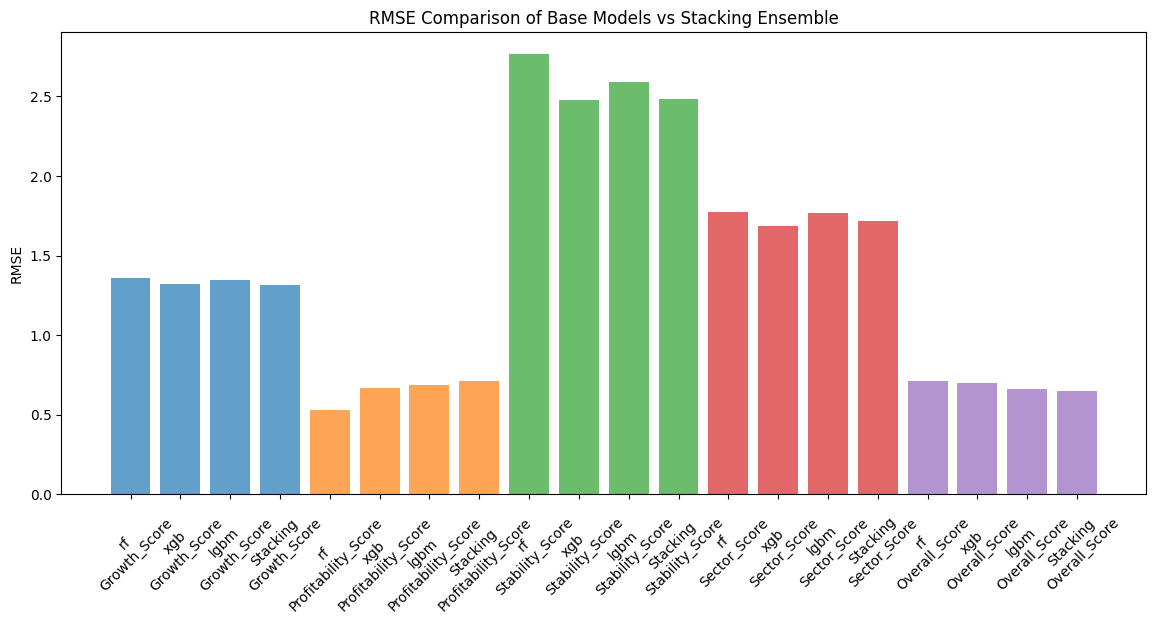

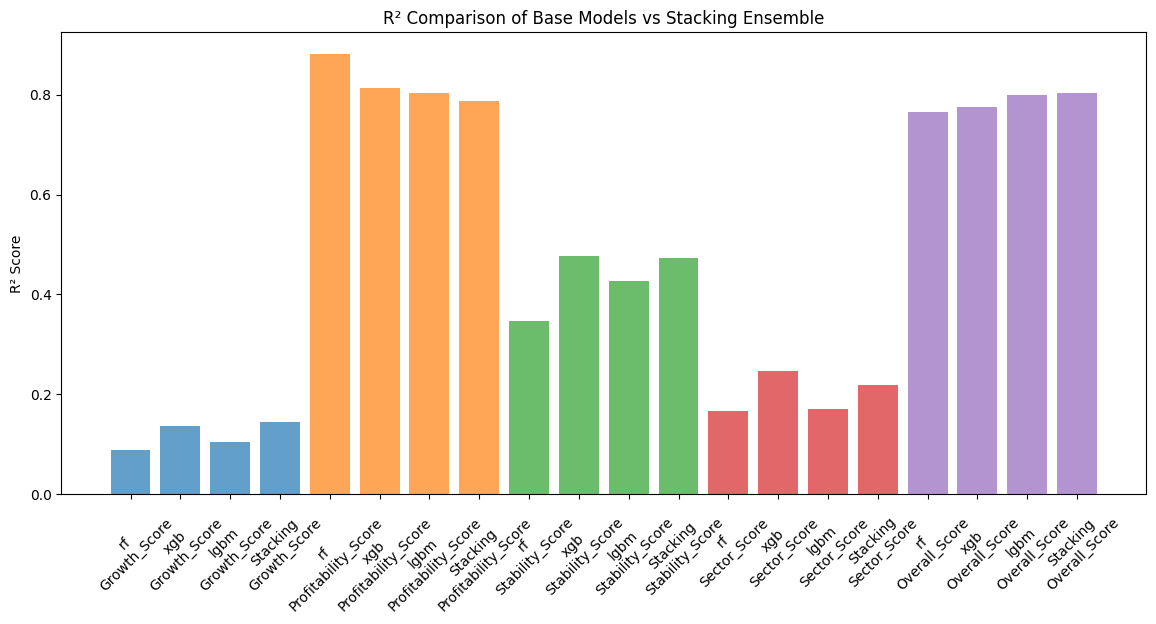

In [ ]:
import matplotlib.pyplot as plt


results = {}

for name, base_model in base_learners:
    model = MultiOutputRegressor(clone(base_model))
    model.fit(X_train, y_train)
    y_pred_base = model.predict(X_val)

    results[name] = {}
    for i, col in enumerate(target_cols):
        mse = mean_squared_error(y_val.iloc[:, i], y_pred_base[:, i])
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_val.iloc[:, i], y_pred_base[:, i])
        r2 = r2_score(y_val.iloc[:, i], y_pred_base[:, i])
        results[name][col] = {"RMSE": rmse, "R2": r2}

#stacking ensemble
y_pred_stack = stacking_model.predict(X_val)
results["Stacking"] = {}
for i, col in enumerate(target_cols):
    mse = mean_squared_error(y_val.iloc[:, i], y_pred_stack[:, i])
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val.iloc[:, i], y_pred_stack[:, i])
    results["Stacking"][col] = {"RMSE": rmse, "R2": r2}


plt.figure(figsize=(14,6))
for i, col in enumerate(target_cols):
    rmses = [results[model][col]["RMSE"] for model in results]
    plt.bar([f"{m}\n{col}" for m in results], rmses, alpha=0.7)
plt.ylabel("RMSE")
plt.title("RMSE Comparison of Base Models vs Stacking Ensemble")
plt.xticks(rotation=45)
plt.show()


plt.figure(figsize=(14,6))
for i, col in enumerate(target_cols):
    r2s = [results[model][col]["R2"] for model in results]
    plt.bar([f"{m}\n{col}" for m in results], r2s, alpha=0.7)
plt.ylabel("R² Score")
plt.title("R² Comparison of Base Models vs Stacking Ensemble")
plt.xticks(rotation=45)
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


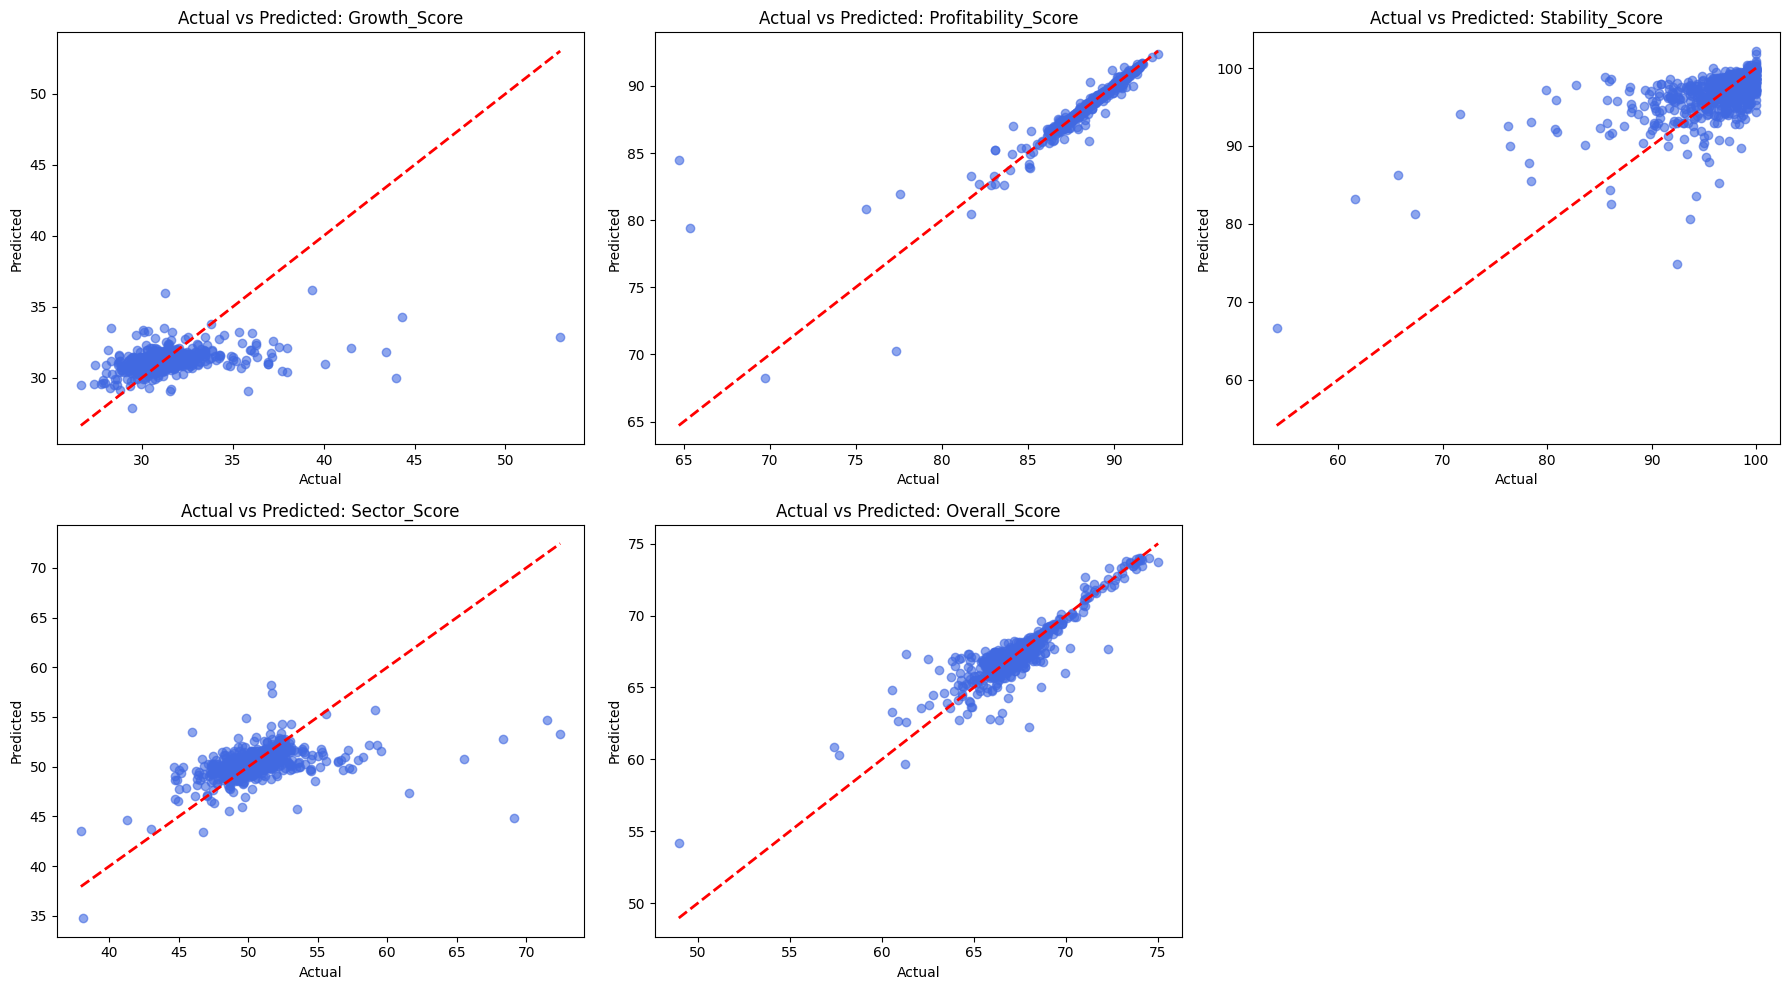

In [ ]:
import matplotlib.pyplot as plt


y_pred = stacking_model.predict(X_val)

plt.figure(figsize=(18, 10))

for i, col in enumerate(target_cols):
    plt.subplot(2, 3, i+1)
    plt.scatter(y_val.iloc[:, i], y_pred[:, i], alpha=0.6, color='royalblue')
    plt.plot([y_val.iloc[:, i].min(), y_val.iloc[:, i].max()],
             [y_val.iloc[:, i].min(), y_val.iloc[:, i].max()],
             'r--', lw=2)  
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Actual vs Predicted: {col}")

plt.tight_layout()
plt.show()


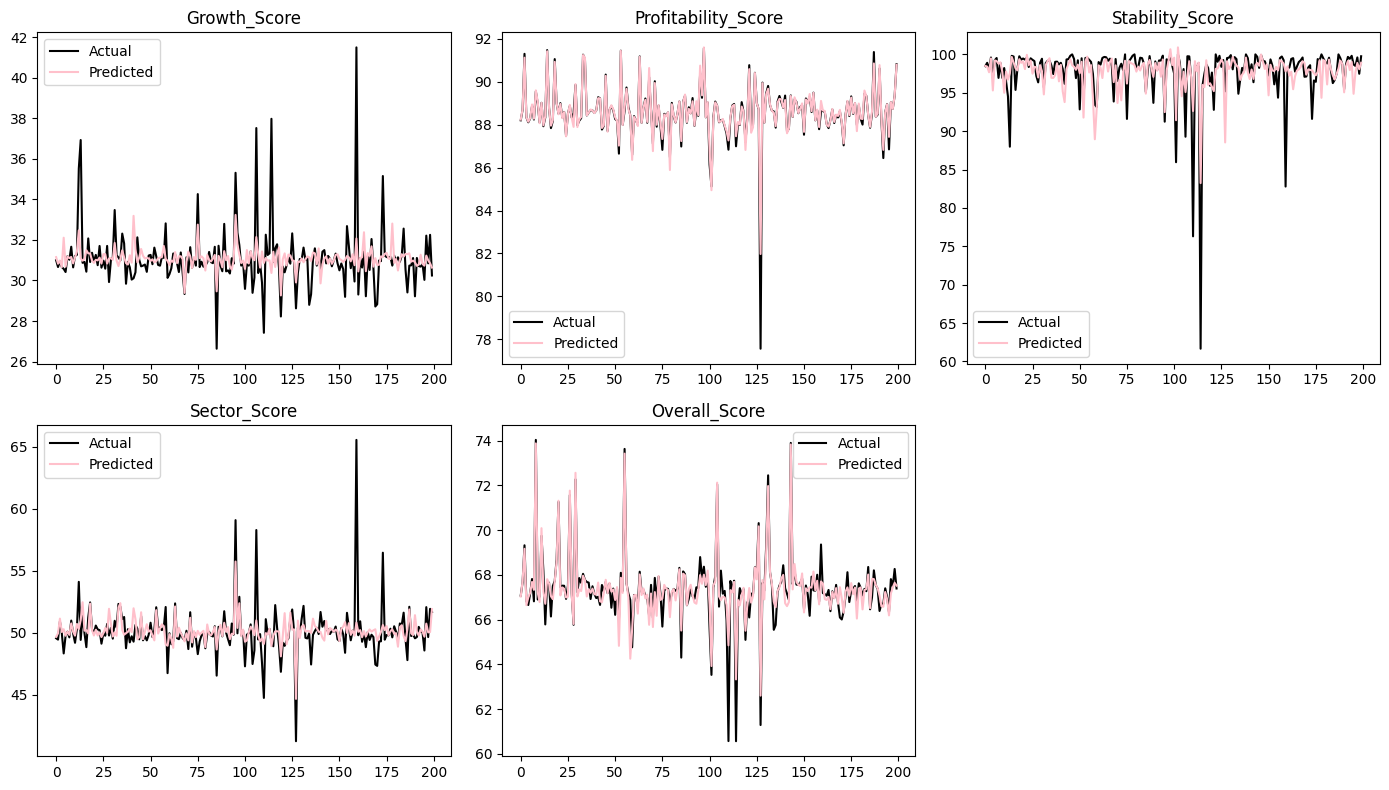

In [ ]:


n_plot = 200  

plt.figure(figsize=(14, 8))
for i, col in enumerate(target_cols):
    plt.subplot(2, 3, i+1)
    plt.plot(y_val.iloc[:n_plot, i].values, label="Actual", color="black")
    plt.plot(y_pred[:n_plot, i], label="Predicted", color="pink")
    plt.title(col)
    plt.legend()

plt.tight_layout()
plt.show()


Data shape: (7574, 24)
Columns: ['FiscalDate', 'Company', 'Sector', 'Revenue', 'Expenses', 'EBITDA', 'Operating Margin %', 'Depreciation', 'Interest', 'PBT', 'Tax', 'Net Profit', 'EPS', 'GST', 'CorpTax%', 'Inflation%', 'RepoRate%', 'USDINR_Close', 'Risk_Score', 'Growth_Score', 'Profitability_Score', 'Stability_Score', 'Sector_Score', 'Overall_Score']
Sequences shape: (3927, 16, 11) (3927, 6)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 16, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 16, 11)    │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_1 (Masking) │ (None, 16, 11)    │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_1 (Any)         │ (None, 16)        │          0 │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 16, 256)   │    143,360 │ masking_1[0][0],  │
│ (Bidirectional)     │                   │            │ any_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 16, 256)   │          0 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 16, 128)   │    164,352 │ dropout_5[0][0],  │
│ (Bidirectional)     │                   │            │ any_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 16, 128)   │          0 │ bidirectional_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 64)        │     41,216 │ dropout_6[0][0],  │
│ (Bidirectional)     │                   │            │ any_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 8)      │      1,944 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8)         │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 72)        │          0 │ dropout_7[0][0],  │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      4,672 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 32)        │          0 │ batch_normalizat

 Total params: 358,206 (1.37 MB)

 Trainable params: 358,014 (1.37 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/120
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - loss: 1.0575 - val_loss: 0.4803 - learning_rate: 5.0000e-04
Epoch 2/120
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - loss: 0.7800 - val_loss: 0.5035 - learning_rate: 5.0000e-04
Epoch 3/120
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.7028 - val_loss: 0.4605 - learning_rate: 5.0000e-04
Epoch 4/120
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 0.6244 - val_loss: 0.4238 - learning_rate: 5.0000e-04
Epoch 5/120
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.6074 - val_loss: 0.3872 - learning_rate: 5.0000e-04
Epoch 6/120
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - loss: 0.5621 - val_loss: 0.3794 - learning_rate: 5.0000e-04
Epoch 7/120
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.5384 - val_loss: 0.3725 - learning_rate: 5.0000e-04
Epoch 8/120
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - loss: 0.5246 - val_loss: 0.3664 - learning_rate: 5.0000e-04
Epoch 9/120
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.5003 - val_loss: 0.36

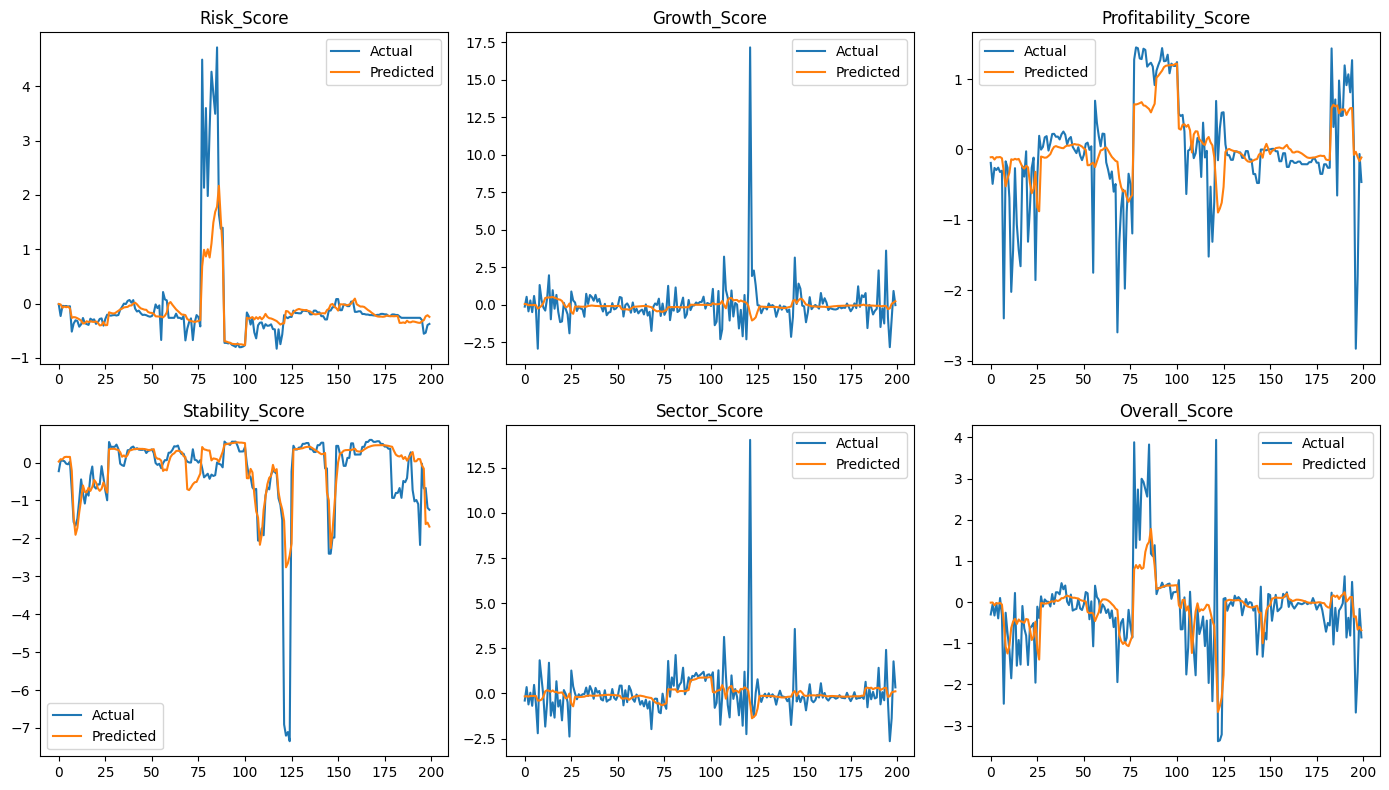


Next quarter prediction for aarti-drugs-ltd:
{'Risk_Score': np.float32(-0.22), 'Growth_Score': np.float32(-0.097), 'Profitability_Score': np.float32(-0.144), 'Stability_Score': np.float32(0.373), 'Sector_Score': np.float32(-0.203), 'Overall_Score': np.float32(-0.063)}

Next quarter prediction for acc-ltd:
{'Risk_Score': np.float32(0.108), 'Growth_Score': np.float32(-0.154), 'Profitability_Score': np.float32(0.005), 'Stability_Score': np.float32(0.284), 'Sector_Score': np.float32(-0.135), 'Overall_Score': np.float32(0.142)}

Next quarter prediction for adani-enterprises-ltd:
{'Risk_Score': np.float32(-0.242), 'Growth_Score': np.float32(-0.29), 'Profitability_Score': np.float32(-0.333), 'Stability_Score': np.float32(-0.923), 'Sector_Score': np.float32(-0.438), 'Overall_Score': np.float32(-0.914)}


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Dense, Concatenate, Dropout,
    Masking, Flatten, BatchNormalization, Bidirectional
)


file_path = "/content/final.xlsx"
df = pd.read_excel(file_path)

print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())

company_col = "Company"
date_col = "FiscalDate"

TARGETS = [
    "Risk_Score",
    "Growth_Score",
    "Profitability_Score",
    "Stability_Score",
    "Sector_Score",
    "Overall_Score",
]

MACRO_FEATURES = ["GST", "CorpTax%", "Inflation%", "RepoRate%", "USDINR_Close"]
SEQ_FEATURES = TARGETS + MACRO_FEATURES


for col in SEQ_FEATURES:
    df[col] = df.groupby(company_col)[col].transform(lambda g: g.ffill().bfill())
df = df.dropna(subset=SEQ_FEATURES)


le = LabelEncoder()
df["Company_Encoded"] = le.fit_transform(df[company_col])

scaler_X = StandardScaler()
scaler_y = StandardScaler()
df[SEQ_FEATURES] = scaler_X.fit_transform(df[SEQ_FEATURES])

SEQ_LEN = 16  

def create_sequences(group):
    X, y, comp = [], [], []
    values = group[SEQ_FEATURES].values
    targets = group[TARGETS].values
    company_id = group["Company_Encoded"].values[0]

    for i in range(len(values) - SEQ_LEN):
        X.append(values[i:i+SEQ_LEN])
        y.append(targets[i+SEQ_LEN])
        comp.append(company_id)

    return np.array(X), np.array(y), np.array(comp)

X_list, y_list, comp_list = [], [], []
for _, g in df.groupby(company_col):
    X_g, y_g, comp_g = create_sequences(g)
    if len(X_g) > 0:
        X_list.append(X_g)
        y_list.append(y_g)
        comp_list.append(comp_g)

X = np.vstack(X_list)
y = np.vstack(y_list)
companies = np.concatenate(comp_list)

print("Sequences shape:", X.shape, y.shape)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train_raw, y_test_raw = y[:split], y[split:]
comp_train, comp_test = companies[:split], companies[split:]


y_train = scaler_y.fit_transform(y_train_raw)
y_test = scaler_y.transform(y_test_raw)

# BiLSTM Model

num_companies = df["Company_Encoded"].nunique()
embed_dim = 8

input_seq = Input(shape=(SEQ_LEN, len(SEQ_FEATURES)))
input_comp = Input(shape=(1,))


x_comp = Embedding(input_dim=num_companies, output_dim=embed_dim)(input_comp)
x_comp = Flatten()(x_comp)


x_seq = Masking()(input_seq)
x_seq = Bidirectional(LSTM(128, return_sequences=True))(x_seq)
x_seq = Dropout(0.2)(x_seq)
x_seq = Bidirectional(LSTM(64, return_sequences=True))(x_seq)
x_seq = Dropout(0.2)(x_seq)
x_seq = Bidirectional(LSTM(32))(x_seq)
x_seq = Dropout(0.2)(x_seq)

x = Concatenate()([x_seq, x_comp])

dense1 = Dense(64, activation="relu")(x)
dense1 = BatchNormalization()(dense1)
dense1 = Dropout(0.2)(dense1)

dense2 = Dense(32, activation="relu")(dense1)
dense2 = BatchNormalization()(dense2)
dense2 = Dropout(0.2)(dense2)

output = Dense(len(TARGETS))(dense2)

model = Model(inputs=[input_seq, input_comp], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss="mae")

model.summary()

es = tf.keras.callbacks.EarlyStopping(patience=12, restore_best_weights=True)
rlr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=6, min_lr=1e-5)

history = model.fit(
    [X_train, comp_train],
    y_train,
    validation_split=0.2,
    epochs=120,
    batch_size=32,
    verbose=1,
    callbacks=[es, rlr]
)

preds_scaled = model.predict([X_test, comp_test], verbose=0)
preds = scaler_y.inverse_transform(preds_scaled)

print("\nMAE per Score:")
for i, col in enumerate(TARGETS):
    mae = mean_absolute_error(y_test_raw[:, i], preds[:, i])
    print(f"{col}: {mae:.4f}")

n_plot = 200
plt.figure(figsize=(14, 8))
for i, col in enumerate(TARGETS):
    plt.subplot(2, 3, i+1)
    plt.plot(y_test_raw[:n_plot, i], label="Actual")
    plt.plot(preds[:n_plot, i], label="Predicted")
    plt.title(col)
    plt.legend()
plt.tight_layout()
plt.show()

def predict_future(company_name, df, model, scaler_X, scaler_y, SEQ_LEN=16):
    if company_name not in df[company_col].unique():
        raise ValueError(f"Company '{company_name}' not found in dataset.")

    
    company_data = df[df[company_col] == company_name].sort_values(by=date_col)
    company_id = int(company_data["Company_Encoded"].iloc[0])

    if len(company_data) < SEQ_LEN:
        raise ValueError(f"Not enough data for {company_name}. Need at least {SEQ_LEN} quarters.")

    
    last_seq = company_data[SEQ_FEATURES].values[-SEQ_LEN:]
    last_seq = np.expand_dims(last_seq, axis=0)  

   
    company_input = np.array([[company_id]], dtype=np.int32)

   
    pred_scaled = model.predict([last_seq, company_input], verbose=0)
    pred = scaler_y.inverse_transform(pred_scaled)[0]

    return {col: round(val, 3) for col, val in zip(TARGETS, pred)}

example_companies = df[company_col].unique()[:3]
for comp in example_companies:
    print(f"\nNext quarter prediction for {comp}:")
    print(predict_future(comp, df, model, scaler_X, scaler_y))
